#### Importing neccessary libraries 

1. **Numpy** for *linear algebra*
2. **Pandas** for reading csv files and DataFrame handling
3. **Tensorflow** for *machine learning*
4. **Keras** for defining the *LSTM model architecture* and regularization
5. Functions such as **train_test_split** for dividing the dataset into training and test set and **GridSearchCV** to tune hyperparameters across a grid of values.
6. **MinMaxScaler** to scale the variable values to a range of $[0,1]$.  
7. **matplotlib** for plotting results
8. **logging** for errors.

In [149]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.model_selection import train_test_split, GridSearchCV
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from itertools import product
import matplotlib.pyplot as plt
import logging

Configuration of logging:

In [150]:
logging.basicConfig(level = logging.INFO, format = '%(asctime)s - %(levelname)s - %(message)s')

Since the model is run in Google Colab with an external GPU for increased computational ability the device which is used needs to be defined:

In [151]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    logging.warning('GPU device not found. Use CPU instead')
else:
    logging.info(f'Found GPU at: {device_name}')

2024-05-22 12:29:13.751397: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-22 12:29:13.751412: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [152]:
logging.info('Loading dataset...')

file_path = '/Users/asger/Documents/GitHub/Deep_Learning_Techniques/Master/Data/macrovariables_featured.csv'
df = pd.read_csv(file_path)
dataset = df.values[:, 1:].astype('float64') # Later this can be changed to float64 for further precision.

diff = dataset[:,:1]

In [173]:
# Define a function to categorize the percent change
def categorize_diff(diff):
    if diff < 0.001:
        return 0  # Price falls
    elif diff > -0.001:
        return 2  # Price rises
    else:
        return 1  # Price stays the same

# Apply the function to y_diff to get the categories
logging.info('Categorizing percent change...')
y_categories = np.array([categorize_diff(pc) for pc in diff])

# Normalizing dataset
logging.info('Normalizing dataset...')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_series = scaler.fit_transform(dataset[:, 1:])

In [154]:
# Function to convert an array of values into a dataset matrix
def create_dataset(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), :])
        y.append(y_categories[i + time_steps])
    return np.array(X), np.array(y)

In [155]:
# Define the grid search parameters
param_grid = {
    'time_steps': [10, 15, 20], # The sequencing
    'lstm_nodes': [32, 64], # No. of nodes to use in the LSTM layer
    'dropout_rate1': [0.1, 0.2], # Dropout rate for the first dropout layer
    'dropout_rate2': [0.1, 0.2], # Second dropout layer
    'hidden_layers': [1, 2], # No. of hidden layers
    'batch_size': [16, 32], # The batch size
    'epochs': [10, 20] # No. of epochs
}

Defining a function to define the model architecture:

In [156]:
# Function to create the model with different dropout rates
def lstm_model(time_steps=15, lstm_nodes=64, dropout_rate1=0.2, dropout_rate2=0.2, optimizer='adam', hidden_layers=1):
    model = Sequential()
    model.add(LSTM(lstm_nodes, input_shape=(time_steps, X_train.shape[2]), return_sequences=(hidden_layers > 1)))
    model.add(Dropout(dropout_rate1))

    for i in range(hidden_layers - 1):
        model.add(LSTM(lstm_nodes, return_sequences=(i != hidden_layers - 2)))
        model.add(Dropout(dropout_rate2))

    model.add(Dense(3, activation='softmax'))  # Output layer with softmax activation
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

Before diving into Google Colab lets define a small subset of the data for the grid search in order to figure out whether or not it will run once in Google Colab:

In [158]:
# Manual grid search
best_score = 0
best_params = {}

logging.info('Starting manual grid search...')
# Calculate number of fits
num_fits = len(param_grid['time_steps']) * len(param_grid['lstm_nodes']) * len(param_grid['dropout_rate1']) * len(param_grid['dropout_rate2']) * len(param_grid['hidden_layers']) * len(param_grid['batch_size']) * len(param_grid['epochs'])
logging.info(f'Number of fits: {num_fits}')

# Iterate over all combinations of hyperparameters
for time_steps, lstm_nodes, dropout_rate1, dropout_rate2, hidden_layers, batch_size, epochs in product(
        param_grid['time_steps'],
        param_grid['lstm_nodes'],
        param_grid['dropout_rate1'],
        param_grid['dropout_rate2'],
        param_grid['hidden_layers'],
        param_grid['batch_size'],
        param_grid['epochs']):
    
    # Create dataset with current time_steps
    logging.info(f'Creating dataset with time_steps={time_steps}...')
    X, y = create_dataset(dataset, time_steps)
    
    # Reshaping design matrix into a 3D tensor (samples, timesteps, features)
    logging.info('Reshaping input...')
    X_tensor = np.reshape(X, (X.shape[0], time_steps, X.shape[2]))
    
    # Splitting the dataset into training and testing
    logging.info('Splitting dataset...')
    X_train, X_test, y_train, y_test = train_test_split(X_tensor, y, test_size=0.2, shuffle=False)
    
    # Use a small subset of the data for the grid search
    subset_size = int(0.01 * len(X_train))
    X_train_subset, y_train_subset = X_train[:subset_size], y_train[:subset_size]

    model = lstm_model(time_steps, lstm_nodes, dropout_rate1, dropout_rate2, 'adam', hidden_layers)
    
    history = model.fit(X_train_subset, y_train_subset, epochs=epochs, batch_size=batch_size, verbose=0, validation_split=0.2)
    score = model.evaluate(X_test, y_test, verbose=0)[1]
    
    logging.info(f"Params: {time_steps}, {lstm_nodes}, {dropout_rate1}, {dropout_rate2}, {hidden_layers}, {batch_size}, {epochs} - Score: {score}")
    
    if score > best_score:
        best_score = score
        best_params = {
            'time_steps': time_steps,
            'lstm_nodes': lstm_nodes,
            'dropout_rate1': dropout_rate1,
            'dropout_rate2': dropout_rate2,
            'hidden_layers': hidden_layers,
            'batch_size': batch_size,
            'epochs': epochs
        }

logging.info(f"Best score: {best_score} with params: {best_params}")

In [ ]:
# Pring amount of fits and parameters

Performing the grid using the previously imported functions:

In [174]:
# Training Final Model with Best Parameters using Subset of Data
logging.info('Training final model with best parameters using subset of data...')
time_steps = best_params['time_steps']
X, y = create_dataset(scaled_series, time_steps)
X_tensor = np.reshape(X, (X.shape[0], time_steps, 1))
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y, test_size=0.2, shuffle=False)

subset_size = int(0.01 * len(X_train))
X_train_subset, y_train_subset = X_train[:subset_size], y_train[:subset_size]

final_model = lstm_model(
    lstm_nodes=best_params['lstm_nodes'],
    dropout_rate1=best_params['dropout_rate1'],
    dropout_rate2=best_params['dropout_rate2'],
    optimizer='adam',
    hidden_layers=best_params['hidden_layers'],
    time_steps=best_params['time_steps']
)

history = final_model.fit(
    X_train_subset, y_train_subset,
    epochs=best_params['epochs'],
    batch_size=best_params['batch_size'],
    validation_data=(X_test, y_test),
    callbacks=[EarlyStopping(monitor='val_loss', patience=10)]
)

ValueError: cannot reshape array of size 1516480 into shape (4739,20,1)

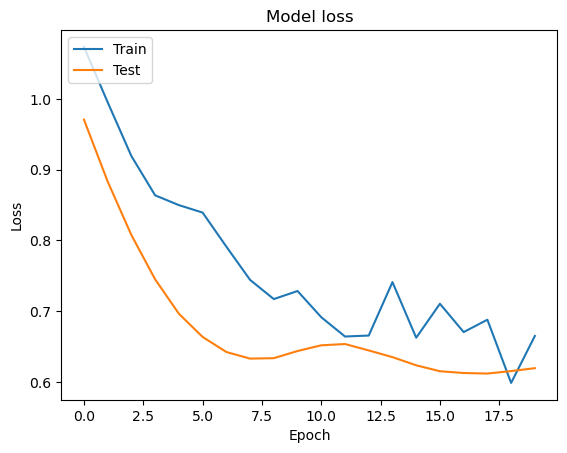

In [159]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()